In [2]:
import os
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
import tensorflow as tf
import warnings              

In [3]:
CAPUCHIN_FILE = os.path.join('Data','audio_dataset', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('Data','audio_dataset', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [4]:
ipd.Audio(CAPUCHIN_FILE)

In [5]:
ipd.Audio(NOT_CAPUCHIN_FILE)

In [6]:
def load_aud(filename):
    wave, sample_rate = librosa.load(filename, sr=None)  # sr=None returns the original sample rate
    return wave, sample_rate


In [7]:
ywave, sr_y = load_aud(CAPUCHIN_FILE)
nwave, sr_n = load_aud(NOT_CAPUCHIN_FILE)

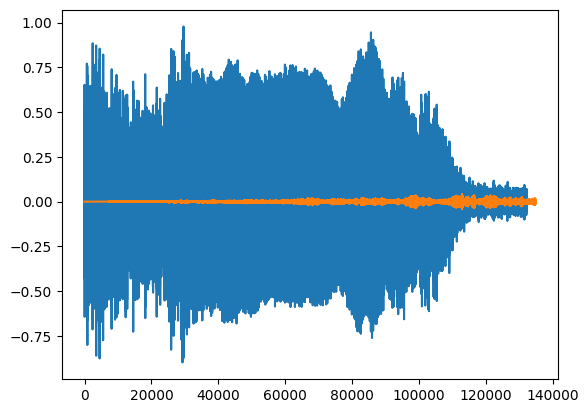

In [8]:
plt.plot(ywave)
plt.plot(nwave)
plt.show()

In [9]:
CAPUCHIN_FILE = os.path.join('Data','audio_dataset', 'Parsed_Capuchinbird_Clips')
NOT_CAPUCHIN_FILE = os.path.join('Data','audio_dataset', 'Parsed_Not_Capuchinbird_Clips')

In [10]:
Positive_dataset = tf.data.Dataset.list_files(CAPUCHIN_FILE+'/*.wav') 
Negative_dataset = tf.data.Dataset.list_files(NOT_CAPUCHIN_FILE+'/*.wav') 

In [11]:
Positive_Samples = tf.data.Dataset.zip((Positive_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(Positive_dataset)))))  
Negative_Samples = tf.data.Dataset.zip((Negative_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(Negative_dataset)))))
data = Positive_Samples.concatenate(Negative_Samples)  

In [12]:
import librosa

def Loading_wav_16k_mono_librosa(filename):
    try:
        
        wav, rate_sample = librosa.load(filename, sr=16000, mono=True)
        return wav
    except Exception as e:
        print(f"Error loading audio file {filename} with librosa: {e}")
        return None


In [13]:
lengthsArray = []
for file in os.listdir(os.path.join('Data','audio_dataset', 'Parsed_Capuchinbird_Clips')):  
    tensor_wave = Loading_wav_16k_mono_librosa(os.path.join('Data','audio_dataset', 'Parsed_Capuchinbird_Clips', file)) 
    lengthsArray.append(len(tensor_wave)) 

In [14]:
tf.math.reduce_mean(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [15]:
tf.math.reduce_min(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
tf.math.reduce_max(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [17]:
def preprocessor(file_path, label): 
    WAV = Loading_wav_16k_mono_librosa(file_path)  
    WAV = WAV[:48000] 
    zero_filler = tf.zeros([48000] - tf.shape(WAV), dtype=tf.float32) 
    WAV = tf.concat([zero_filler, WAV],0)   
    spectrogram = tf.signal.stft(WAV, frame_length=320, frame_step=32) 
    spectrogram = tf.abs(spectrogram)  
    spectrogram = tf.expand_dims(spectrogram, axis=2) 
    return spectrogram, label

In [18]:
filepath, label = Positive_Samples.shuffle(buffer_size=10000).as_numpy_iterator().next() 

In [19]:
spectrogram, label = preprocessor(filepath, label) 

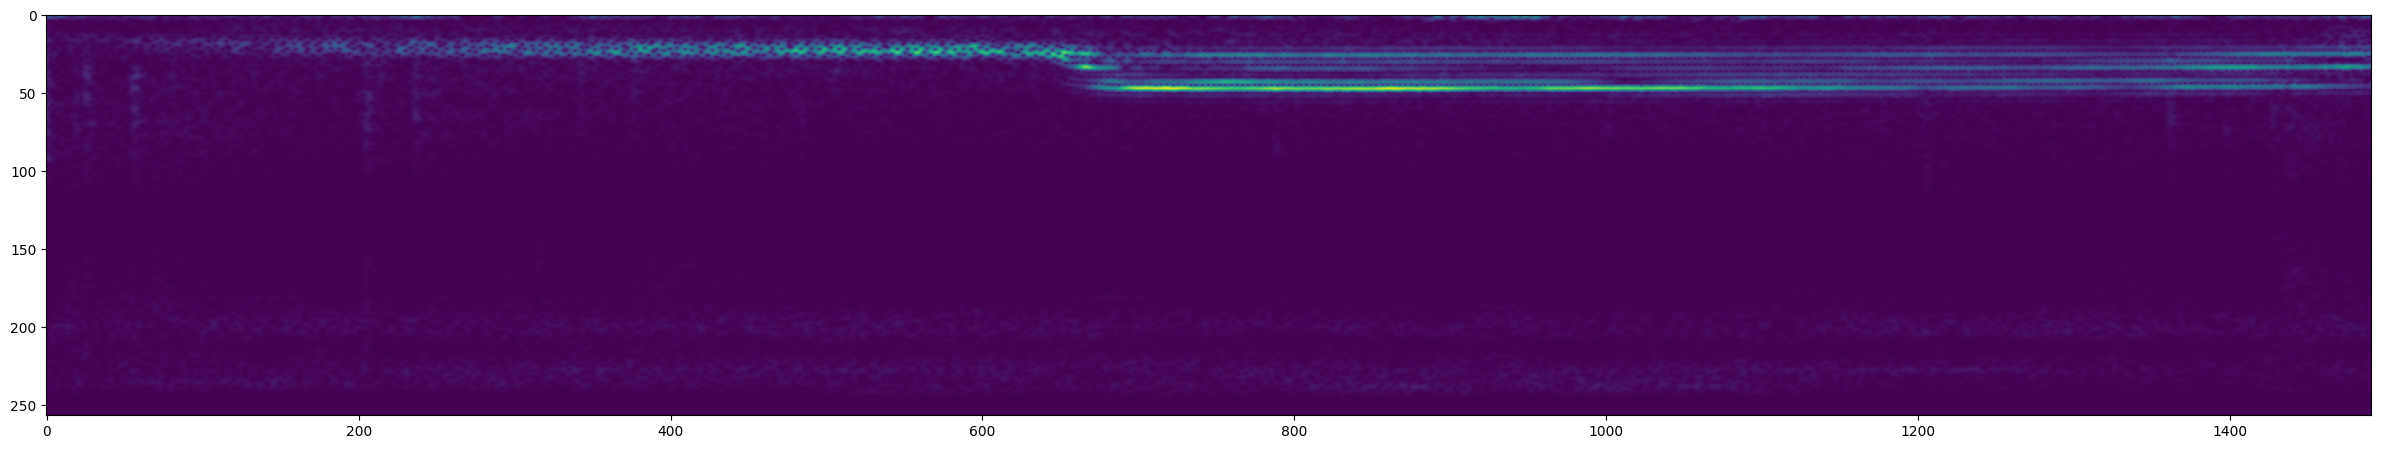

In [20]:
plt.figure(figsize=(30,20))              
plt.imshow(tf.transpose(spectrogram)[0]) 
plt.show()

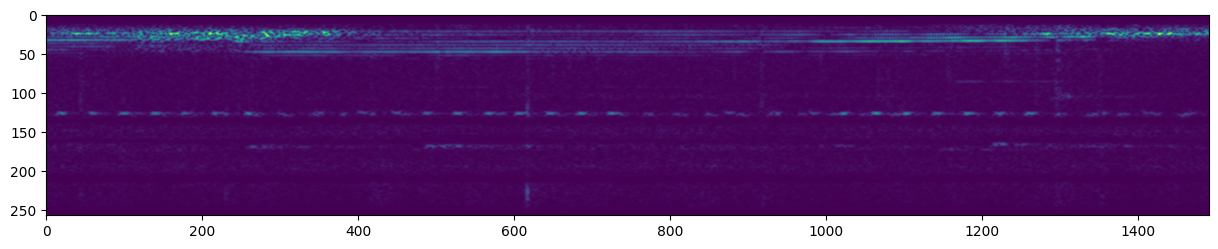

In [24]:
filepath,label = Positive_Samples.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = preprocessor(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

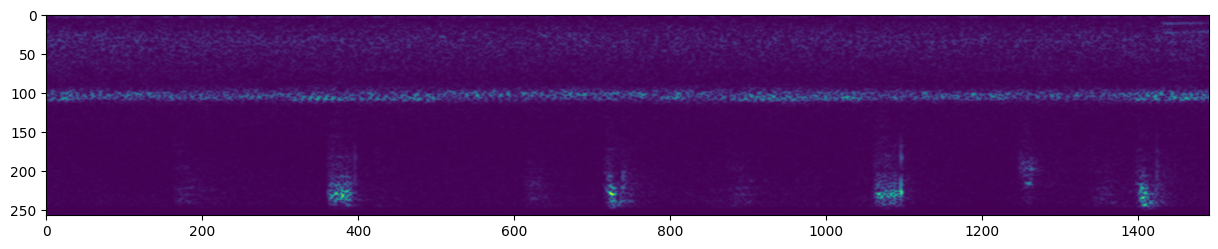

In [25]:
filepath,label = Negative_Samples.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = preprocessor(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

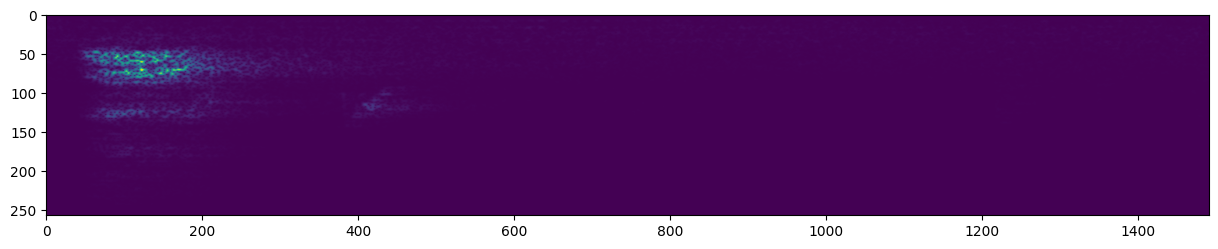

In [26]:
filepath,label = Negative_Samples.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = preprocessor(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [29]:
data = data.map(preprocessor)

Error loading audio file Tensor("args_0:0", shape=(), dtype=string) with librosa: Invalid file: <tf.Tensor 'args_0:0' shape=() dtype=string>


TypeError: in user code:

    File "C:\Users\Richard Patrick\AppData\Local\Temp\ipykernel_9912\327502919.py", line 3, in preprocessor  *
        WAV = WAV[:48000]

    TypeError: 'NoneType' object is not subscriptable


In [ ]:
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8) 